# iris데이터 회귀분석

## pyspark 기본 셋팅

In [1]:
import os
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

### (1) DataFrame 생성

In [2]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])
iris.head()
irisDf=spark.createDataFrame(iris)
irisDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



### (2) 데이터와 회귀선 그래프

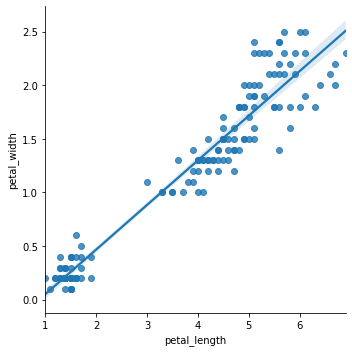

In [3]:
import seaborn as sns

sns.lmplot(x="petal_length", y="petal_width", data=iris)

### (3) Spark를 사용하여 회귀분석하고 계수 출력

In [4]:
(trainDf, testDf) = irisDf.randomSplit([0.6, 0.4])

In [5]:
trainDf.count()

82

In [6]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="species", outputCol="speIndex")

In [7]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="speIndex", outputCol="speVec")

In [8]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ["speVec", "petal_width"],
                                   outputCol = 'features')

In [9]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='petal_length', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [10]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer, encoder, va, lr])

In [11]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

In [12]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept))

Coefficients: [-1.1292718533144874,0.0,1.1991418115038361]
Intercept: 2.604


### (4) 실제와 예측 출력

In [13]:
modelTestDf=model.transform(testDf)

In [14]:
modelTestDf.select('petal_length','prediction').show(10)

+------------+------------------+
|petal_length|        prediction|
+------------+------------------+
|         1.1|1.5950706486308144|
|         1.3|1.7149848297811978|
|         1.3|1.8348990109315815|
|         1.5|1.7149848297811978|
|         1.4|1.5950706486308144|
|         4.5|  4.64296940035144|
|         1.5|1.5950706486308144|
|         1.5|1.5950706486308144|
|         3.3|3.8035701322987543|
|         1.5|1.7149848297811978|
+------------+------------------+
only showing top 10 rows



### (5) 정확성 평가

In [15]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_length", predictionCol="prediction", metricName="rmse")

In [16]:
rmse=evaluator.evaluate(modelTestDf)

In [17]:
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

'Root Mean Squared Error (RMSE) on test data: 0.570'

In [18]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_length", predictionCol="prediction", metricName="r2")

In [19]:
f"r2: {evaluator.evaluate(modelTestDf):.3f}"

'r2: 0.885'